# Implementing and Training ConvCNPs for Hydrology

### Import required packages

In [ ]:
%load_ext autoreload
%autoreload 2

from IPython import display

import os
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import pandas as pd
import pdb
import torch
import torch.nn as nn
import pickle

import scipy.stats

# from sklearn import preprocessing
# from scipy.special import inv_boxcox
# from scipy.stats import boxcox
import stheno.torch as stheno

#import convcnp.data
# import convcnp.data_hydro_2
import data_hydro_2_extended
# import convcnp.data_365
# import convcnp.data_loader_pytorch
import NSE
# from metrics import *
#import convcnp.task_preprocessing as tp

from experiment import report_loss, RunningAverage, save_checkpoint
from utils import gaussian_logpdf, gamma_logpdf, init_sequential_weights, to_multiple, to_numpy, gamma_stats
from plot_utils import *
# from transformations import *
from architectures import SimpleConv, UNet, SeparableConv1d, Conv1d, DepthSepConv1d
from convcnp_architectures import DeepSet, ConvDeepSet, FinalLayer, ConvCNP
from task_utils import task_to_device, loaded_task, try_to_delete

from numpy import loadtxt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from transformations import rev_transform, rev_transform_tensor

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


### Import data

In [2]:
%%time
filepath = r"C:\Users\Sior AMD-4\Downloads\daymet_data_seed05.csv"
df_raw = pd.read_csv(filepath)

CPU times: total: 17.3 s
Wall time: 19.2 s


In [143]:
df_raw

,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa),basin,YR,MNTH,...,DATE,DOY,doy_sin,doy_cos,hru08,hru02,hru04,id,id_lag,year
12723,41126.39,0.00,272.40,0.0,16.65,6.47,960.76,1022500,1980,10,...,1980-10-01,275,-0.017062,0.001896,hru_01022500,hru_01,hru_0102,hru_01022500_1980,hru_01022500_1979,1980
12724,40780.79,0.00,252.49,0.0,17.64,8.20,1095.90,1022500,1980,10,...,1980-10-02,276,-0.007624,0.015382,hru_01022500,hru_01,hru_0102,hru_01022500_1980,hru_01022500_1979,1980
12725,40665.18,5.96,135.18,0.0,17.44,11.00,1320.03,1022500,1980,10,...,1980-10-03,277,0.008824,0.014726,hru_01022500,hru_01,hru_0102,hru_01022500_1980,hru_01022500_1979,1980
12726,40435.20,31.30,135.31,0.0,14.57,8.35,1108.03,1022500,1980,10,...,1980-10-04,278,0.017159,0.000531,hru_01022500,hru_01,hru_0102,hru_01022500_1980,hru_01022500_1979,1980
12727,40089.58,2.39,209.76,0.0,13.42,5.39,897.95,1022500,1980,10,...,1980-10-05,279,0.009718,-0.014152,hru_01022500,hru_01,hru_0102,hru_01022500_1980,hru_01022500_1979,1980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8236952,32313.39,0.00,198.99,0.0,8.59,1.22,667.70,11532500,2014,12,...,2014-12-27,361,0.004796,-0.016484,hru_11532500,hru_11,hru_1153,hru_11532500_2014,hru_11532500_2013,2014
8236953,32360.00,2.26,173.72,0.0,7.74,0.53,637.97,11532500,2014,12,...,2014-12-28,362,-0.011279,-0.012942,hru_11532500,hru_11,hru_1153,hru_11532500_2014,hru_11532500_2013,2014
8236954,32405.00,3.70,136.40,0.0,4.58,-1.17,565.92,11532500,2014,12,...,2014-12-29,363,-0.016984,0.002498,hru_11532500,hru_11,hru_1153,hru_11532500_2014,hru_11532500_2013,2014
8236955,32458.46,3.75,168.65,0.0,4.63,-3.33,482.25,11532500,2014,12,...,2014-12-30,364,-0.007074,0.015642,hru_11532500,hru_11,hru_1153,hru_11532500_2014,hru_11532500_2013,2014


In [3]:
# basins_file = r'../../../ealstm_regional_modelling/ealstm_regional_modeling/data/basin_list.txt'
basins_file = r"C:\Users\Sior AMD-4\Downloads\basin_list.txt"
selected_basins = loadtxt(basins_file, comments="#", delimiter=",", unpack=False, dtype="int")

In [4]:
%%time

df_raw = df_raw[df_raw['basin'].isin(selected_basins)]
print("Length of dataframe for selected basin: ", len(df_raw))

df_raw.drop(['MOD_RUN'],axis=1,inplace=True)

df_raw.drop_duplicates(inplace=True)
print("Length of dataframe after dropping duplicates: ", len(df_raw))

df_raw = df_raw[df_raw['OBS_RUN']>=0]
print("Length of dataframe after filtering out error values: ", len(df_raw))

df_raw['year'] = df_raw['YR']

Length of dataframe for selected basin:  6521041
Length of dataframe after dropping duplicates:  6520841
Length of dataframe after filtering out error values:  6518953
CPU times: total: 13.5 s
Wall time: 14.4 s


In [78]:
df = df_raw.copy()

In [79]:
dist='gaussian'

transformation = 'None'

# transformation = 'log'
trans_fields = [#'OBS_RUN',
                'prcp(mm/day)']

if transformation == 'log':
    for trans_field in trans_fields:
        df[trans_field] = log_transform(df_raw[trans_field], 1)
        print(f"log of {trans_field}")

# transformation = 'NOboxcox'
trans_fields = ['prcp(mm/day)']
        
if transformation == 'boxcox':
    for trans_field in trans_fields:
        df[trans_field], lambda_val = boxcox_transform(df_raw[trans_field], 1e-6)
        
        for ch in ['(',')','/']:
            trans_field = trans_field.replace(ch,"_")
        
        exec("lambda_" + trans_field + " = " + str(lambda_val))
        print("lambda_" + trans_field + " = ", lambda_val)


In [80]:
fields = ['OBS_RUN',
          'prcp(mm/day)', 
          'dayl(s)',
          'srad(W/m2)','swe(mm)', 'tmax(C)','tmin(C)', 'vp(Pa)',
          'year'
         ]

for field in fields:
    if field == 'OBS_RUN':
        #df[field], q_min, q_max = normalise(df[field],stats=True)
        df[field], q_mu, q_sigma = standardise(df[field], stats=True)
    else:
        #df[field] = normalise(df[field])
        df[field] = standardise(df[field], stats=False)

In [81]:
if dist=='gamma':
    Q_shift = abs(df['OBS_RUN'].min()) + 1
    df['OBS_RUN'] = df['OBS_RUN'] + Q_shift
    print(f'Shifted by {Q_shift}')
else:
    print('No shift')

No shift


### Load dict

In [82]:
# a_file = open("train_test_splits/k5fold_split.pkl", "rb")
# k5fold_dict = pickle.load(a_file)

## Train test sets

In [83]:
tr = te = selected_basins

In [84]:
# tr = k5fold_dict['train_basins_01']
# te = k5fold_dict['test_basins_01']

print(f'Train test split random: {len(tr)} train and {len(te)} test locations')

Train test split random: 531 train and 531 test locations


In [85]:
df['OBS_RUN_mean'] = df.groupby('hru08')['OBS_RUN'].transform(lambda x: x.mean())

s_date_tr = '1990-10-01' #'1980-10-01'
e_date_tr = '1992-09-30' #'1995-09-30'

s_date_te = '1990-10-01' #'1980-10-01'
e_date_te = '1992-09-30' #'1995-09-30'

context_channels = ['OBS_RUN',
                    #'dayl(s)',
                    'doy_cos','doy_sin',
                    'prcp(mm/day)', 
                    'srad(W/m2)',  
                    'tmax(C)',
                    'tmin(C)', 
                    'vp(Pa)',
                   ]

target_channels = context_channels
target_val_channel = ['OBS_RUN_mean']

context_mask = [0,1,1,1,1,1,1,1]
target_mask = [0,1,1,1,1,1,1,1]

attributes = [#'gauge_id', 
               'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow',
               'aridity', 'high_prec_freq', 'high_prec_dur', 
                #'high_prec_timing',
               'low_prec_freq', 'low_prec_dur', 
                #'low_prec_timing', 'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class', 'glim_2nd_class_frac',
               'carbonate_rocks_frac', #'geol_porostiy', 
                'geol_permeability', 
                #'q_mean','runoff_ratio', 'slope_fdc', 'baseflow_index', 'stream_elas', 'q5',
               #'q95', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur',
               #'zero_q_freq', 'hfd_mean', 'huc_02', 'gauge_name',
               'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity','soil_conductivity', 
                'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 
                #'water_frac', 'organic_frac', 'other_frac', 
                #'gauge_lat','gauge_lon', 
                'elev_mean', 'slope_mean', 
                #'area_gages2',
                'area_geospa_fabric', 
                'frac_forest', 'lai_max', 'lai_diff', 'gvf_max','gvf_diff', 
                #'dom_land_cover_frac', 'dom_land_cover', 'root_depth_50','root_depth_99', 'hru08'
                ]

df_train = df[(df['DATE'] >= s_date_tr) & (df['DATE'] <= e_date_tr) & (df['basin'].isin(tr))].copy()
df_test_both = df[(df['DATE'] >= s_date_te) & (df['DATE'] <= e_date_te) & (df['basin'].isin(te))].copy()
df_test_catchment = df[(df['DATE'] >= s_date_tr) & (df['DATE'] <= e_date_tr) & (df['basin'].isin(te))].copy()
df_test_temporal = df[(df['DATE'] >= s_date_te) & (df['DATE'] <= e_date_te) & (df['basin'].isin(tr))].copy()

list_to_drop = ['MNTH','DY','hru02','hru04','RAIM','TAIR','PET','ET','SWE','swe(mm)','PRCP','seed','id_lag','HR']

df_train.drop(list_to_drop,axis=1,inplace=True)
df_test_both.drop(list_to_drop,axis=1,inplace=True)
df_test_catchment.drop(list_to_drop,axis=1,inplace=True)
df_test_temporal.drop(list_to_drop,axis=1,inplace=True)

df_train.reset_index(drop=True,inplace=True)
df_test_temporal.reset_index(drop=True,inplace=True)
df_test_catchment.reset_index(drop=True,inplace=True)
df_test_both.reset_index(drop=True,inplace=True)

In [86]:
observed_at_target_flag = True
feature_embedding_flag = True
feature_embedding_key_flag = True
extrapolate_flag = False

timeslice = 365

min_train_points = 50
max_train_points = 165
min_test_points = 150
max_test_points = 200

## Data Generation

In [87]:
# path = '../../data/camels_processed/attibutes.csv'
path = r"C:\Users\Sior AMD-4\Downloads\attibutes.csv"
df_att = pd.read_csv(path)
numeric_attributes = df_att.select_dtypes('float64').columns.tolist()
#from sklearn import preprocessing
#df_att_n = pd.DataFrame()
for att in numeric_attributes:
    df_att[att] = standardise(df_att[att])

#df_att_n['hru08'] = df_att['hru08']
#df_att.describe()

## Model

In [88]:
%%capture

# Define parameters
dynamic_embedding_dims = 10
static_embedding_dims = 5

concat_static_features = False
static_feature_embedding = True

static_embedding_location = "after_encoder"
static_feature_missing_data = True
static_masking_rate=0.25

encoder_out_channels = 8

rho_in_channels = encoder_out_channels if static_embedding_location != "after_encoder" else 8 + static_embedding_dims
static_embedding_in_channels = 2 if static_feature_missing_data else len(attributes)

# Instantiate ConvCNP
model = ConvCNP(in_channels = len(context_channels),
                #rho=SimpleConv(),
                rho=UNet(),
                #rho=DepthSepConv1d(in_channels=rho_in_channels, conv_channels=64, num_layers=7, kernel_size=15),
                points_per_unit=64*8,
                dynamic_embedding_dims=dynamic_embedding_dims,
                static_embedding_dims=static_embedding_dims,
                static_feature_embedding=static_feature_embedding,
                static_embedding_in_channels=static_embedding_in_channels,
                static_feature_missing_data=static_feature_missing_data,
                static_embedding_location=static_embedding_location,
                distribution=dist)

# Assign model to device
model.to(device)

In [89]:
model.num_params

51378

## Training Data Generation

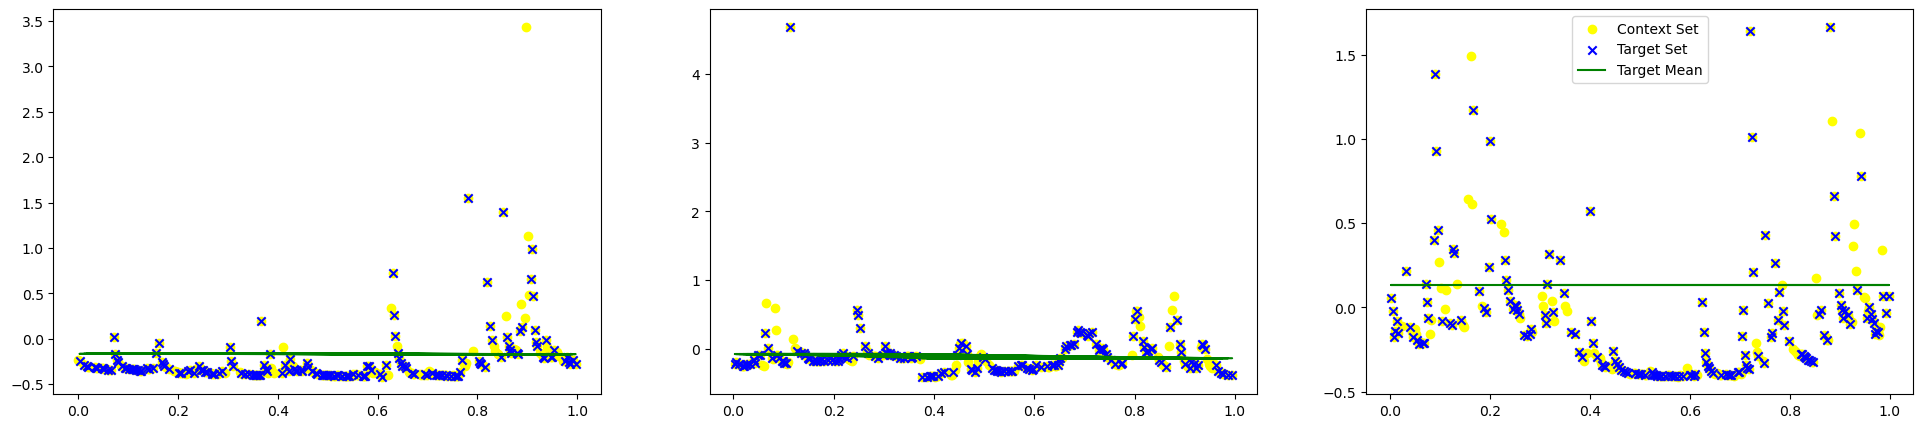

In [90]:
gen = data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_train,
                                            df_att = df_att,
                                            batch_size = 16*2,
                                            num_tasks = 256,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = extrapolate_flag,
                                            timeslice = timeslice,
                                            dropout_rate = 0.3,
                                            concat_static_features = concat_static_features,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device='cpu',
                                            )

task = gen.generate_task()
fig = plt.figure(figsize=(24, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_task(task, i, legend=i==2)
plt.show()

## Training Methods

With our model in place, let's next define a training procedure. The `train` function below performs one training epoch (as defined by the number of tasks in an epoch from our data generator) as follows:
1. Iterate over the tasks in the epoch
2. For every task, condition on the context set, and make (Gaussian) predictions at the target locations.
3. Compute the log-likelihood of the predictions under the target set.
4. Backpropagate the error from the (negative) log-likelihood to the model parameters 

The `RunningAverage` average object will maintain a running average of the negative log-likelihood. In addition, we provide a plotting function so as to visually monitor the progress of the training procedure.

In [113]:
def train(data, model, opt, dist='gaussian'):
    #Perform a training epoch.
    ravg = RunningAverage()
    ravg_nse = RunningAverage() 
    model.train()
    task_obj_list = []
    
    for step, task in enumerate(data):
        
        task = loaded_task(task)
        
        y_loc, y_scale = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], 
                               task['feature'], task['m'], 
                               static_masking_rate=static_masking_rate, 
                               embedding=feature_embedding_flag)
        
        if dist == 'gaussian':
            y_mean, y_std = y_loc, y_scale
            obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        elif dist == 'gamma':
            y_mean, y_std = gamma_stats(y_loc, y_scale)
            obj = -gamma_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        elif dist == 'gaussian_fixed':
            y_mean, y_std = y_loc, y_scale
            obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale/y_scale, 'batched_mean')
        
        obj.backward()
        opt.step()
        opt.zero_grad()
              
        obj_nse = NSE.nse_tensor(rev_transform_tensor(task['y_target']),rev_transform_tensor(task['y_target_val']),rev_transform_tensor(y_mean))
        task_obj_list.append(obj.item())
        ravg.update(obj.item(), data.batch_size)
        ravg_nse.update(obj_nse.item(), data.batch_size)
        
        if step % 100 == 0:
            print("step %s -- avg training loss is %.3f" % (step, ravg.avg)) 
            
    plt.plot(task_obj_list)
    plt.show
        
    return ravg.avg, ravg_nse.avg

In [125]:
# Create a fixed set of outputs to predict at when plotting.
x_test = torch.linspace(0., 1.,timeslice)[None, :, None].to(device)

In [ ]:
from plot_utils import plot_model_task

In [95]:
# Instantiate data generator for testing.
NUM_TEST_TASKS = 128
gen_test = data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test_both,
                                            df_att = df_att,
                                            batch_size = 16*2,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = False,
                                            concat_static_features=concat_static_features,
                                            timeslice = timeslice,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device = 'cpu'
                                            )

In [96]:
# Instantiate data generator for validation.
NUM_TEST_TASKS = 128
gen_val = data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test_catchment,
                                            df_att = df_att,
                                            batch_size = 16*2,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = False,
                                            concat_static_features=concat_static_features,
                                            timeslice = timeslice,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device = 'cpu'
                                            )

In [97]:
def get_batch_size(x):
    if x.__class__ == 'torch.utils.data.dataloader.DataLoader':
        return x.dataset.gen.batch_size
    else:
        return x.batch_size

In [126]:
def test(gen_test,model,dist='gaussian',fig_flag=False):
    # Compute average task log-likelihood.
    ravg = RunningAverage()
    ravg_nse = RunningAverage()
    
    model.eval()
    start = time.time()
    
    with torch.no_grad():
        for step, task in enumerate(gen_test):
            torch.cuda.empty_cache()
            task = loaded_task(task)
            y_loc, y_scale = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], 
                                   task['feature'], task['m'], 
                                   static_masking_rate = static_masking_rate,
                                   embedding=feature_embedding_flag)        
            if dist == 'gaussian':
                y_mean, y_std = y_loc, y_scale
                obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
            elif dist == 'gamma':
                y_mean, y_std = gamma_stats(y_loc, y_scale)
                obj = -gamma_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
            if dist == 'gaussian_fixed':
                y_mean, y_std = y_loc, y_scale
                obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale/y_scale, 'batched_mean')
            
            batch_size = get_batch_size(gen_test)
            
            obj_nse = NSE.nse_tensor(rev_transform_tensor(task['y_target']),rev_transform_tensor(task['y_target_val']),rev_transform_tensor(y_mean))        
            ravg.update(obj.item(), batch_size)
            #print(batch_size)
            ravg_nse.update(obj_nse.item(), batch_size)

    if fig_flag:
        fig = plt.figure(figsize=(24, 15))
        for i in range(3):
            plt.subplot(3, 1, i + 1)
            plot_model_task(model, task, timeslice, idx=i, legend=i==2, dist=dist)
        plt.show()

        elapsed = time.time() - start        
        print('Test NLL: %.3f -- NSE: %.3f -- time: %.3f' % (ravg.avg, ravg_nse.avg, elapsed))
    
    return ravg.avg

In [99]:
from experiment import WorkingDirectory, generate_root


## Training loop for the model

Now we can write a standard PyTorch optimization loop. First, we instantiate an optimizer (here we use an Adam optimizer). Then, we simply iterate for as many epochs as necessary to train the model. Every so often we will print the training error (since the data are generated on the fly, this is also a reasonable estimator for the held out error), and produce a plot demonstrating the model performance. Note that the next block of code will train the model for 100 epochs. This may take some time, and it is highly recommended to do so with a GPU!

In [100]:
change_folder = True

if change_folder:
    experiment_name = 'test_002'
    wd = WorkingDirectory(generate_root(experiment_name))

Root: _experiments\2024-05-08_15-20-10_test-002


In [101]:
load_model = False
load_dict = False

load_root = '_experiments/2020-08-01_22-10-37_k5fold-01-gamma-staticfs-after-encoder-unet'

if load_model:
    PATH = f'{load_root}/model_best.pth.tar'
    #PATH = f'{load_root}/e_61_loss_151.753.pth.tar'
    model.load_state_dict(torch.load(PATH))
    
if load_dict:
    a_file = open(os.path.join(load_root,"loss_dict.pkl"), "rb")
    loss_dict = pickle.load(a_file)
    a_file.close()
    
    epoch_list = loss_dict['epochs']
    train_obj_list = loss_dict['training_loss'] 
    train_nse_list = loss_dict['training_nse'] 
    test_obj_list = loss_dict['test_loss'] 

In [115]:
reset_epochs = True

if reset_epochs:
    train_obj_list, train_nse_list, test_obj_list, epoch_list = [], [], [], []

In [103]:
torch.cuda.empty_cache()
try_to_delete(['task','minitask'])

task deleted
minitask does not exist


In [122]:
# importlib.reload(convcnp.data_loader_pytorch)
from data_loader_pytorch import *

gen.batch_size = 16*2
gen_val.batch_size = 16*2
gen_test.batch_size = 16*2

gen.dropout_rate = 0
gen_val.dropout_rate = 0
gen_test.dropout_rate = 0
static_masking_rate = 0

train_dataloader = DataLoader(dataset=HydroDataset(gen,num_tasks_epoch=16), batch_size=1, num_workers=16, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(dataset=HydroDataset(gen_test,num_tasks_epoch=256), batch_size=1, num_workers=8, shuffle=False, pin_memory=True)
val_dataloader = DataLoader(dataset=HydroDataset(gen_val,num_tasks_epoch=256), batch_size=1, num_workers=8, shuffle=False, pin_memory=True)

In [109]:
load_best = False
if load_best:
    model.load_state_dict(torch.load(os.path.join(wd.root,'model_best.pth.tar')))

In [123]:
dist = "gaussian_fixed"

Epoch 41 ¦ train NLL: 184.020 ¦ test NLL: 180.904 ¦ train NSE: -3.271 ¦ time: 206.554


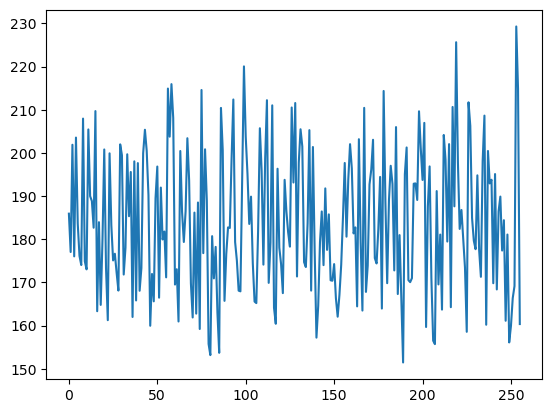

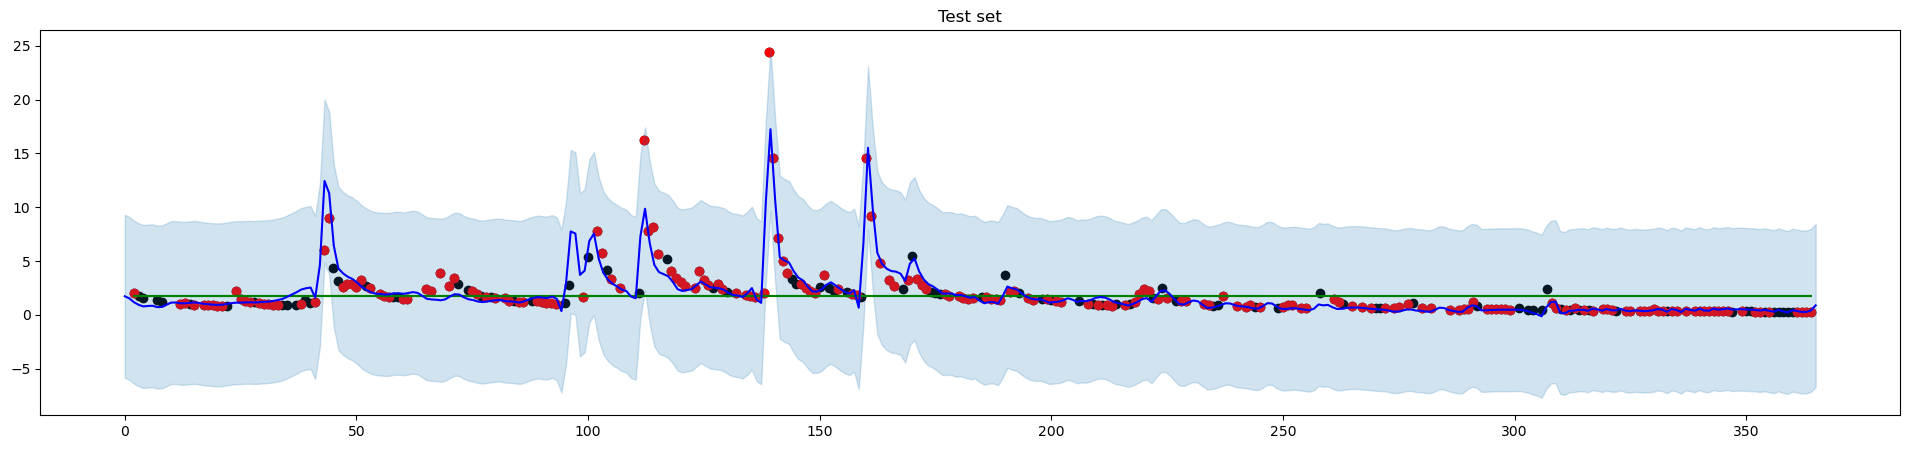

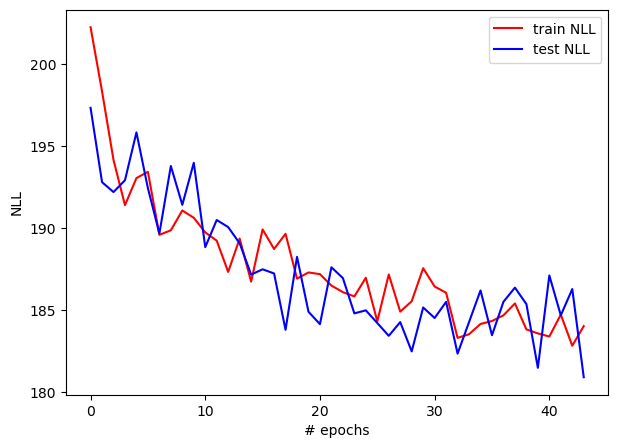

step 0 -- avg training loss is 172.029


KeyboardInterrupt: 

In [127]:
torch.autograd.set_detect_anomaly(False)

# Some training hyper-parameters:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
PLOT_FREQ = 1

plot_model = True

if len(epoch_list)>0:
    last_epoch = epoch_list[-1]
else:
    last_epoch = 0

# Initialize optimizer
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Run the training loop.
for epoch in range(NUM_EPOCHS):
    # Compute training objective.
    start_time = time.time()
    train_obj, train_nse = train(gen, model, opt, dist=dist)

    epoch_list.append(epoch+last_epoch)
    train_obj_list.append(train_obj)
    train_nse_list.append(train_nse)
    
    #torch.cuda.empty_cache()
    test_obj = test(gen_val,model,dist=dist)
    #torch.cuda.empty_cache()
    test_obj_list.append(test_obj)
    
    elapsed = time.time() - start_time
    
    print('Epoch %s ¦ train NLL: %.3f ¦ test NLL: %.3f ¦ train NSE: %.3f ¦ time: %.3f' % (epoch+last_epoch, train_obj, test_obj, train_nse, elapsed))

    # Plot model behaviour every now and again.
    if (epoch % PLOT_FREQ == 0) and plot_model:
        task = task_to_device(gen_val.generate_task())
        fig = plt.figure(figsize=(24, 5))
        for i in range(1):
            plt.subplot(1, 1, i + 1)
            plot_model_task(model, task, timeslice=timeslice, idx=i, legend=i==2, dist=dist)
        plt.title('Test set')
        display.clear_output(wait=True)
        #display.display(plt.gcf())
        #plot training loss

    print('Epoch %s ¦ train NLL: %.3f ¦ test NLL: %.3f ¦ train NSE: %.3f ¦ time: %.3f' % (epoch + last_epoch, train_obj, test_obj, train_nse, elapsed))
    torch.cuda.empty_cache()
    plot_training_loss(train_obj_list, test_obj_list)
    plt.show()
    
    save_as_best = True if test_obj == min(test_obj_list) else False
    save_checkpoint(wd,model.state_dict(),is_best=save_as_best)
    
    PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch + last_epoch, test_obj))
    torch.save(model.state_dict(), PATH)

In [128]:
save_dict = True

if save_dict:
    model_hyperparams={}
    model_hyperparams['lr'] = LEARNING_RATE
    model_hyperparams['distribution'] = dist
    model_hyperparams['train_batch_size'] = gen.batch_size
    model_hyperparams['batches_per_epoch'] = train_dataloader.dataset.num_tasks_epoch
    model_hyperparams['static_masking_rate'] = static_masking_rate
    model_hyperparams['dynamic masking rate'] = gen.dropout_rate
    model_hyperparams['static_embedding_dims'] = static_embedding_dims
    model_hyperparams['dynamic_embedding_dims'] = dynamic_embedding_dims

    a_file = open(os.path.join(wd.root,"model_hyperparams.pkl"), "wb")
    pickle.dump(model_hyperparams, a_file)
    a_file.close()
    print('Saved successfuly')


Saved successfuly


In [129]:
save_dict = True

if save_dict:
    loss_dict={}
    loss_dict['epochs'] = epoch_list
    loss_dict['training_loss'] = train_obj_list
    loss_dict['training_nse'] = train_nse_list
    loss_dict['test_loss'] = test_obj_list

    a_file = open(os.path.join(wd.root,"loss_dict.pkl"), "wb")
    pickle.dump(loss_dict, a_file)
    a_file.close()
    print('Saved successfuly')
    

Saved successfuly


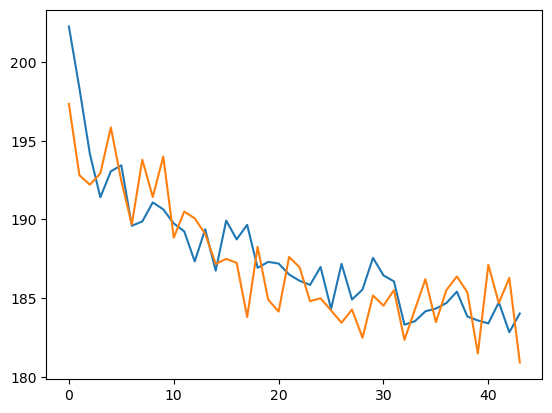

In [131]:
plt.plot(train_obj_list)
plt.plot(test_obj_list)
#plt.ylim([-100,100])

## Test model

In [46]:
#ROOT_PATH = '_experiments/2020-07-30_11-26-34_k5fold-01-gaussian-log-staticfs-after-encoder-unet'
#model.load_state_dict(torch.load(os.path.join(ROOT_PATH, 'model_best.pth.tar')))

In [70]:
torch.cuda.empty_cache()
try_to_delete(['task'])

task deleted


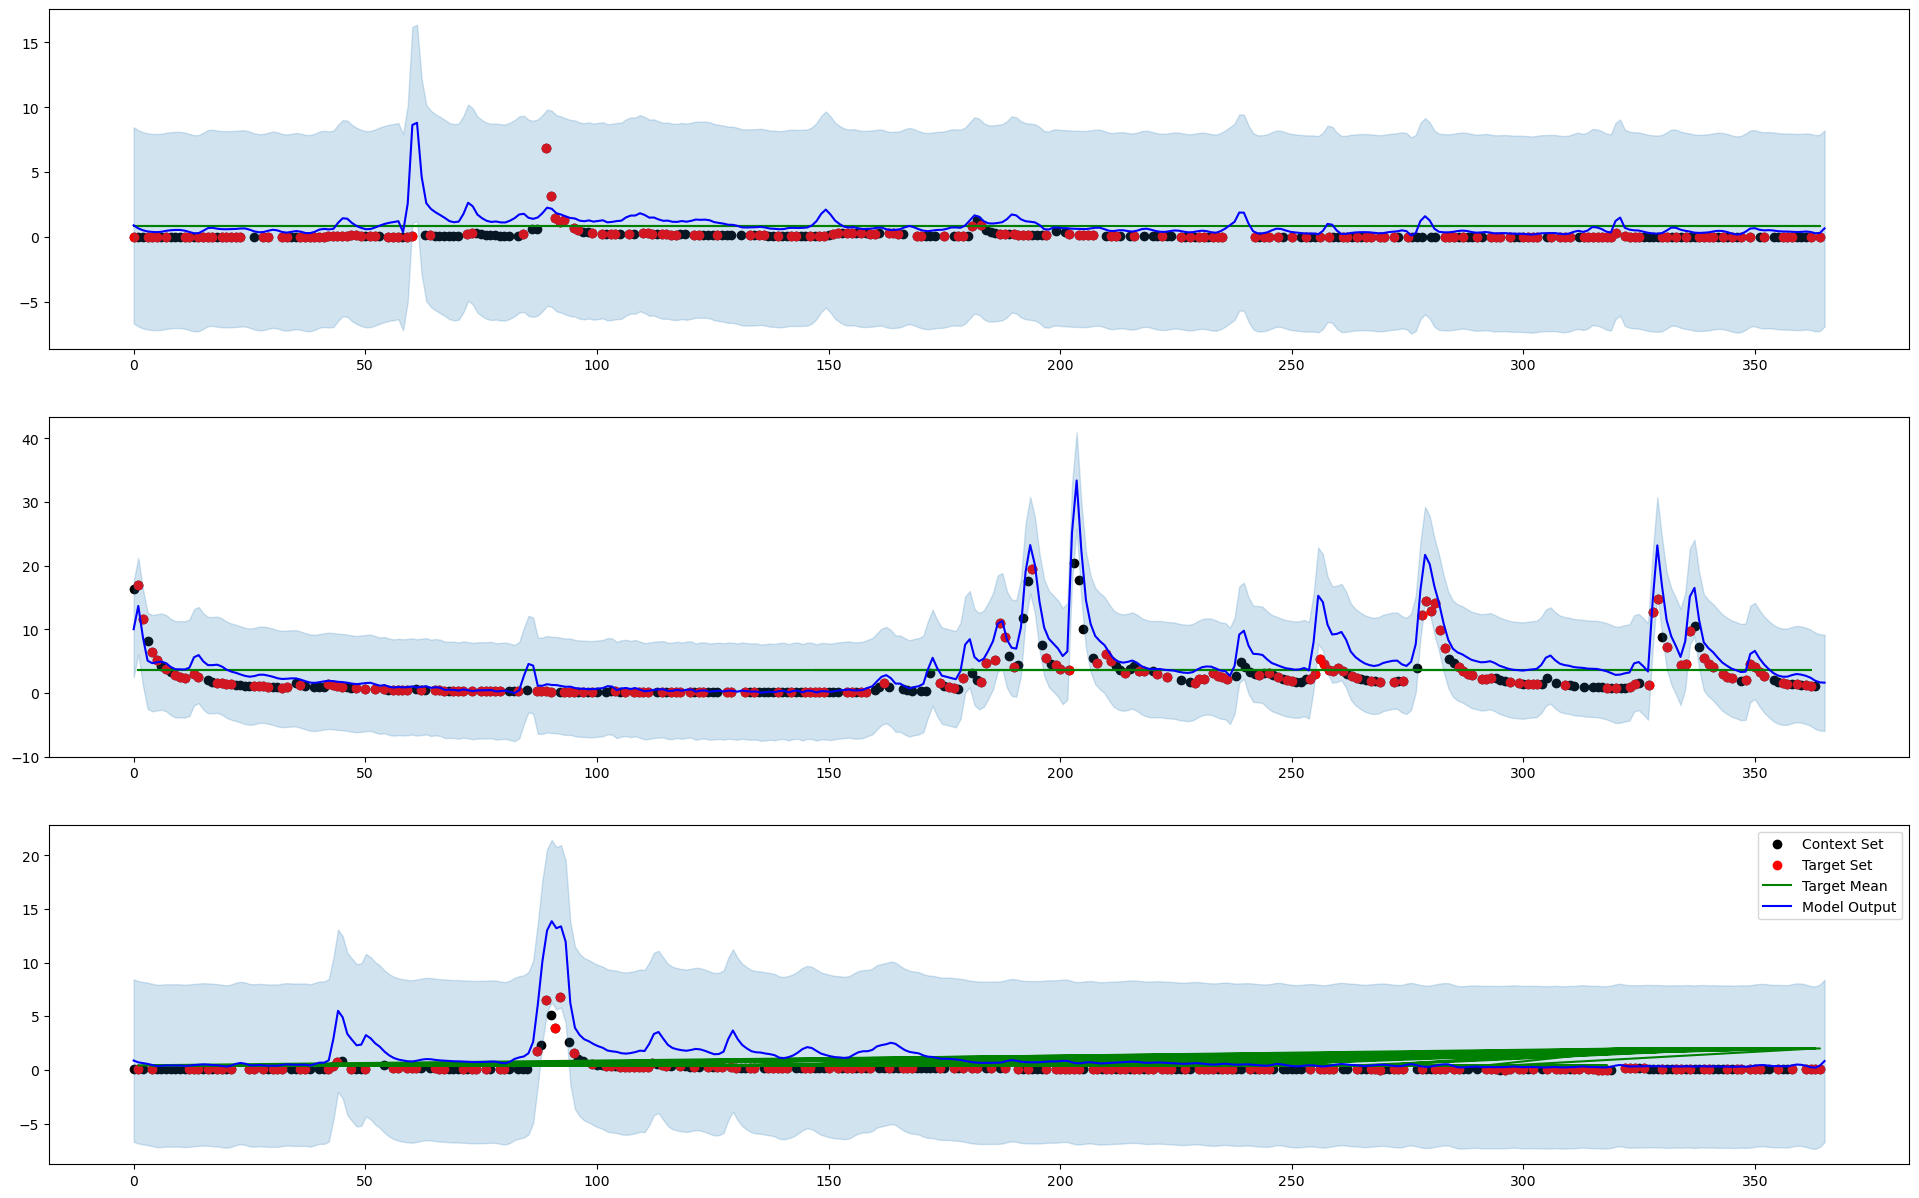

Test NLL: 185.308 -- NSE: -7.730 -- time: 34.607


185.30759072303772

In [133]:
gen_for_test = data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test_both,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = 32,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = extrapolate_flag,
                                            timeslice = timeslice,
                                            dropout_rate = 0,
                                            concat_static_features = False,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device='cpu',
                                            )
        

tester = DataLoader(dataset=HydroDataset(gen_for_test,num_tasks_epoch=64), batch_size=1, shuffle=False, num_workers=8, pin_memory=False)
test(tester,model,dist=dist,fig_flag=True)

## Evaluation 

We can also evaluate the trained model to get better estimates of its performance. To do so, we will first introduce an additional data generator that will generate far more tasks for us. Then, we will loop over many tasks, and compute (and print) the average log-likelihood.

In [ ]:
"""%%capture
#load model
##model = TheModelClass(*args, **kwargs)
PATH = '../../saved_models/model_022.pt'
model.load_state_dict(torch.load(PATH))
model.eval()"""

In [ ]:
"""model_number = 23
save_model_name = f'model_{model_number}_{dist}_static-features_{static_embedding_location}_{s_date_tr}_to_{e_date_tr}'
save_model_name"""

In [ ]:
"""PATH = r'..\..\saved_models\model_022.pt'
torch.save(model.state_dict(),PATH)"""

In [40]:
ROOT_PATH = '_experiments/2020-08-02_00-31-53_k5fold-01-gamma-staticfs-after-encoder-unet/'
PATH = f'{ROOT_PATH}/model_best.pth.tar'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## Test NSE performance at 365/1-day ahead task

In [135]:
from metrics import *
import scipy.stats
df_test = df_test_temporal

In [136]:
var_list = ['minitask','task']
try_to_delete(var_list)

minitask does not exist
task deleted


In [142]:
# Instantiate data generator for testing.
NUM_TEST_TASKS = 10
gen_365 = data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            concat_static_features = concat_static_features,
                                            extrapolate = True,
                                            timeslice = 365,
                                            min_train_points=364,
                                            min_test_points=1,
                                            max_train_points=364,
                                            max_test_points=1,
                                            device='cpu')

out = np.array([])
out_2 = np.array([])

# Compute average task log-likelihood.
basins = df_test['hru08'].unique().tolist()
print(len(basins))
b=0
for basin in basins[:]:
    
    b+=1
    
    ravg = RunningAverage()
    ravg_nse = RunningAverage()
    model.eval()
    start = time.time()
    
    pred_mu = np.array([])
    pred_mu2 = np.array([])
    pred_sigma = np.array([])
    pred_loc = np.array([])
    pred_scale = np.array([])
    observations = np.array([])
    DOY = np.array([])
    YR = np.array([])
    HRU = np.array([])
    
    alpha_nse = np.array([])
    beta_nse = np.array([])
    nse_index = np.array([])
    fhv = np.array([])
    flv = np.array([])
    fms = np.array([])
    
    with torch.no_grad():    
        years = df_test['YR'][df_test['hru08']==basin].unique().tolist()
        years = sorted(years)[1:]
        
        """duration = 1
        y = np.random.randint(len(years)-duration)
        years = years[y:y+duration]"""
        
        testtime_dataloader = DataLoader(dataset=HydroTestDataset(gen_365,years=years,basin=basin),
                                         batch_size=1, num_workers=16, pin_memory=True)
        
        for step, task in enumerate(testtime_dataloader):
            
            torch.cuda.empty_cache()
            
            task = loaded_task(task,device='cpu')
            
            year=years[step]
        
        #for year in years[:]:
        #    task = gen_365.generate_test_task(year,basin)
            
            chunk_size = 50
            chunks = np.arange(0, task['x_context'].shape[0],chunk_size)
            
            #minitask = task.copy()
            #minitask = loaded_task(minitask)
            
            for i in range(len(chunks)):
                
                torch.cuda.empty_cache()
                                
                if i+1 == len(chunks):
                    s = chunks[i]
                    e = task['x'].shape[0]
                else:
                    s = chunks[i]
                    e = chunks[i+1]

                minitask = {}
                for k,v in task.items():
                    minitask[k] = task[k][s:e]
                
                minitask = loaded_task(minitask)
                
                minibatch_size = minitask['x_context'].shape[0]
                
                y_mean, y_std = model(minitask['x_context'], minitask['y_context'], 
                                      minitask['x_target'],minitask['y_att'], 
                                      minitask['feature'],minitask['m'],
                                      static_masking_rate=0,
                                      embedding=feature_embedding_flag)
                                
                if dist == 'gaussian':
                    obj = -gaussian_logpdf(minitask['y_target'], y_mean, y_std, 'batched_mean')
                elif dist == 'gaussian_fixed':
                    obj = -gaussian_logpdf(minitask['y_target'], y_mean, y_std/y_std, 'batched_mean')
                elif dist == 'gamma':
                    obj = -gamma_logpdf(minitask['y_target'], y_mean, y_std, 'batched_mean')
                
                #y_mu, y_sigma = rev_lognormal(to_numpy(y_mean), to_numpy(y_std))
                
                if dist == 'gamma':
                    y_loc = y_mean
                    y_scale = y_std
                    g_mean = torch.distributions.gamma.Gamma(y_mean, y_std).mean
                    g_var = torch.distributions.gamma.Gamma(y_mean, y_std).variance
                    y_mean = g_mean
                    y_std = torch.sqrt(g_var)
                

                ravg.update(obj.item() / minibatch_size, minibatch_size)
                
                observed = rev_transform(to_numpy(minitask['y_target']))
                
                observations = np.append(observations, observed)
                pred_mu = np.append(pred_mu, to_numpy(y_mean))
                pred_sigma = np.append(pred_sigma, to_numpy(y_std))
                
                if dist=='gamma':
                    pred_loc = np.append(pred_loc, to_numpy(y_loc))
                    pred_scale = np.append(pred_scale, to_numpy(y_scale))
                    
                #DOY = np.append(DOY, np.arange(s+1,e+1))
                DOY = np.append(DOY, np.arange(1,minibatch_size+1))
                YR = np.append(YR, np.ones(minibatch_size)*year)
                HRU = np.append(HRU, np.array([basin] * minibatch_size))
                
            #print(f'{step}, {basin}, {year}')
                
        alpha_nse = np.append(alpha_nse, calc_alpha_nse(observations,rev_transform(pred_mu)))
        beta_nse = np.append(beta_nse, calc_beta_nse(observations,rev_transform(pred_mu)))
        nse_index = np.append(nse_index, calc_nse(observations,rev_transform(pred_mu)))
        fhv = np.append(fhv, calc_fdc_fhv(observations,rev_transform(pred_mu)))
        flv = np.append(flv, calc_fdc_flv(observations,rev_transform(pred_mu)))
        fms = np.append(fms, calc_fdc_fms(observations,rev_transform(pred_mu)))   
            
        out_basin = np.transpose(np.vstack((HRU,YR,DOY,observations,pred_mu,pred_sigma,pred_loc,pred_scale)))
        out_basin_2 = np.transpose(np.vstack((alpha_nse,beta_nse,nse_index,fhv,flv,fms)))
        
        fig = plt.figure(figsize=(24, 5))
        
        x = np.arange(len(observations))
        
        # Plot model predictions.
        plt.plot(x,observations, label='Observed', color='green')
        plt.plot(x,np.ones(len(observations))*observations.mean(), label='Observed mean', linestyle='dashed', color='green')
        plt.plot(x,rev_transform(pred_mu), label='Modelled(ConvCNP)', color='blue')
        
        if (dist=='gaussian') or (dist=='gaussian_fixed'):
            plt.fill_between(x,
                             rev_transform(pred_mu + 2 * pred_sigma),
                             rev_transform(pred_mu - 2 * pred_sigma),
                             color='tab:blue', alpha=0.2)

        elif dist=='gamma':
            p05 = scipy.stats.gamma.ppf(0.05, pred_loc, 0, 1/pred_scale)
            p95 = scipy.stats.gamma.ppf(0.95, pred_loc, 0, 1/pred_scale)
            plt.fill_between(x, rev_transform(p05), rev_transform(p95),color='tab:blue', alpha=0.2)
        
        plt.legend()
        plt.show()

        elapsed = time.time() - start        
        
        print(f'{b}. Basin {basin} (period: {years[0]}-{years[-1]}): LL=%.3f -- NSE=%.3f -- time=%.3f' % (-ravg.avg, calc_nse(observations,pred_mu), elapsed))
    
    if out.shape[0]!=0:
        out = np.vstack((out,out_basin))
        out_2 = np.vstack((out_2,out_basin_2))
    else:
        out = out_basin
        out_2 = out_basin_2

531


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 364 and the array at index 6 has size 0

In [62]:
importlib.reload(convcnp.transformations)
from convcnp.transformations import rev_lognormal

1999

In [64]:
df_output = pd.DataFrame(out,columns=['HRU','YR','DOY','OBS_RUN','MOD_RUN_MU','MOD_RUN_SIGMA','PRED_LOC','PRED_SCALE'])
df_output_2 = pd.DataFrame(out_2, columns=['alpha_nse','beta_nse','nse_index','fhv','flv','fms'])

In [65]:
PATH = '_experiments/2020-08-02_00-31-53_k5fold-01-gamma-staticfs-after-encoder-unet'
df_output.to_csv(os.path.join(PATH,f'results_PGB_model_best_epoch_85.csv'),index=False)
df_output_2.to_csv(os.path.join(PATH,f'metrics_PGB_model_best_epoch_85.csv'),index=False)

In [66]:
"""df_output_test_both_40basins = df_output.copy()
df_output_test_both_40basins_2 = df_output_2.copy()"""

'df_output_test_both_40basins = df_output.copy()\ndf_output_test_both_40basins_2 = df_output_2.copy()'

424


/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/donal/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= 

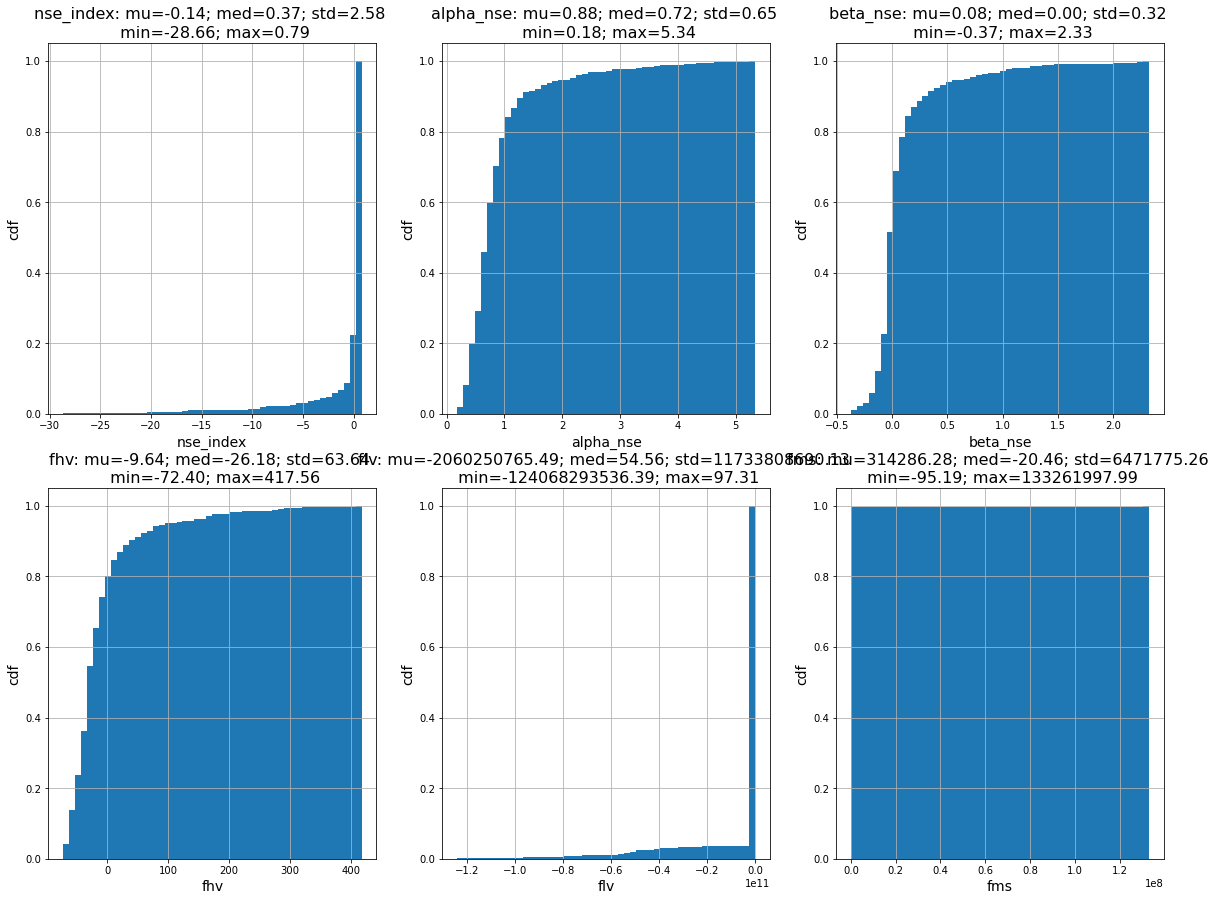

In [67]:
hrus = df_output['HRU'].unique()
nse_array = np.array([])
for hru in hrus:
    df_hru = df_output[df_output['HRU']==hru]
    obs = rev_transform(df_hru['OBS_RUN'].values.astype(np.float))
    mean_obs = np.ones(len(obs))*obs.mean()
    #print(mean_obs)
    mod = rev_transform(df_hru['MOD_RUN_MU'].values.astype(np.float))
    nse_array = np.append(nse_array, NSE.nse(obs,mean_obs,mod))

#print(f"Median NSE = {np.median(nse_array)}")
#print(f"Mean NSE = {nse_array.mean()}")
#print(f"NSE std = {nse_array.std()}")
print(len(nse_array))

list_metrics = ['nse_index','alpha_nse','beta_nse','fhv','flv','fms']

i = 0
fig = plt.figure(figsize=[20,15])
for m in list_metrics:
    i += 1
    plt.subplot(2,3,i)
    plt.hist(df_output_2[m], bins=50, density=True, 
         histtype='stepfilled',
         cumulative=True)
    plt.grid()
    
    plt.ylabel("cdf",fontsize = 14)
    plt.xlabel(m,fontsize=14)
    plt.title("%s: mu=%.2f; med=%.2f; std=%.2f \n min=%.2f; max=%.2f" % (m, df_output_2[m].mean(), df_output_2[m].median(), df_output_2[m].std(), df_output_2[m].min(), df_output_2[m].max()), fontsize=16)
    #plt.show()

In [68]:
df_output.columns

Index(['HRU', 'YR', 'DOY', 'OBS_RUN', 'MOD_RUN_MU', 'MOD_RUN_SIGMA',
       'PRED_LOC', 'PRED_SCALE'],
      dtype='object')

In [139]:
fig = plt.figure(figsize=[20,20])
for j in range(10):
    time_slice = 365
    x = np.arange(time_slice)
    hru_list = df_output['HRU'].unique()
    rand = np.random.randint(len(hru_list))
    hru_rand = hru_list[rand]

    i = np.random.randint(len(df_output['OBS_RUN'][df_output['HRU']==hru_rand])-time_slice)
    print(i)

    #fig = plt.figure(figsize=(24, 5))

    obs = df_output['OBS_RUN'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
    pred_mu = df_output['MOD_RUN_MU'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
    pred_sigma = df_output['MOD_RUN_SIGMA'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
    doy = df_output['DOY'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)

    if dist=='gamma':
        pred_loc = df_output['PRED_LOC'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
        pred_scale = df_output['PRED_SCALE'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
    
    plt.subplot(5,2,j+1)
    
    # Plot model predictions.
    plt.plot(x,obs, label='Observed', color='green')
    plt.plot(x,rev_transform(pred_mu), label='Model Output', color='blue')

    show_std = True

    if show_std:
        if dist=='gaussian':
            plt.fill_between(x,
                             rev_transform(pred_mu + 2 * pred_sigma),
                             rev_transform(pred_mu - 2 * pred_sigma),
                             color='tab:blue', alpha=0.2)

        elif dist=='gamma':
            p05 = rev_transform(scipy.stats.gamma.ppf(0.05, pred_loc, 0, 1/pred_scale))
            p95 = rev_transform(scipy.stats.gamma.ppf(0.95, pred_loc, 0, 1/pred_scale))
            p05[p05<0]=0
            #pdb.set_trace()
            plt.fill_between(x,
                            p05,
                            p95,
                            color='tab:blue', alpha=0.2)

    NSE = calc_nse(obs,rev_transform(pred_mu))
    plt.title("NSE = %.3f" % NSE, fontsize = 15)
    
    plt.xlim([0,time_slice])
    if (j+2)%2==0:
        plt.ylabel('Discharge (m3/s)', fontsize=15)
    plt.legend()
    plt.tight_layout()
    #plt.show()
    
SAVE_PATH  = '/home/donal/Documents/mg963/MResProject/figures'
plt.savefig(os.path.join(SAVE_PATH,('timeseries_gamma_PGB_%s.png' % (np.random.randint(100000)))), dpi=500, bbox_inches='tight') # 6

NameError: name 'df_output' is not defined

<Figure size 2000x2000 with 0 Axes>

## Test with known datanse_array

In [ ]:
import pickle
path = "test_tasks/generate_test_task_0.pkl"
a_file = open(path, "rb")
task = pickle.load(a_file)
a_file.close()

In [ ]:
import importlib
importlib.reload(convcnp.feature_mask)

In [ ]:
#import convcnp.feature_mask as mask
task = mask.task_mask(task, context_mask, target_mask)

In [ ]:
# Compute average task log-likelihood.
batch_size = task['x_context'].shape[0]
ravg = RunningAverage()
model.eval()
with torch.no_grad():
    y_mean, y_std = model(task['x_context'], task['y_context'], task['x_target'],task['f'],task['m'],embedding=feature_embedding_flag)
    obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
        
    ravg.update(obj.item() / gen_test.batch_size, gen_test.batch_size)
        
    fig = plt.figure(figsize=(24, 25))
    for i in range(5):
        plt.subplot(5, 1, i + 1)
        plot_model_task(model, task, idx=i, legend=i==2)
    plt.show()
    
elapsed = time.time() - start        
print('Model averages a log likelihood of %.3f on unseen tasks -- time: %.3f' % (-ravg.avg, elapsed))